# Using Amazon Forecast's Machine Learning tools to predict P&G future sales in Oman
Chirayu Khimji

MSc Applied Computational Science and Engineering

Imperial College London


Note: This notebook will not run on other machines due to privacy aspect of uploading P&G data (data is stored locally on my machine), its purpose is just to showcase the power of data science for KR CPG group.

The overall process for using Amazon Forecast is the following:

1. Create a Dataset Group, this is the large box that isolates models and the data they are trained on from each other.
2. Create a Dataset, in Forecast there are 3 types of dataset, Target Time Series, Related Time Series, and Item Metadata. The Target Time Series is required, the others provide additional context with certain algorithms. 
3. Import data, this moves the information from S3 into a storage volume where the data can be used for training and validation.
4. Train a model, Forecast automates this process for you but you can also select particular algorithms, and you can provide your own hyper parameters or use Hyper Parameter Optimization(HPO) to determine the most performant values for you.
5. Deploy a Predictor, here you are deploying your model so you can use it to generate a forecast.
6. Query the Forecast, given a request bounded by time for an item, return the forecast for it. Once you have this you can evaluate its performance or use it to guide your decisions about the future.

In this notebook we walk through the steps outlined above. One additional task that will be done here is to trim part of our training and validation data so that we can measure the accuracy of a forecast against our predictions. 

## Table Of Contents
* Setup
* Data Preparation
* Creating the Dataset Group and Dataset
* Next Steps


**Read Every Cell FULLY before executing it**

For more informations about APIs, please check the [documentation](https://docs.aws.amazon.com/forecast/latest/dg/what-is-forecast.html)

## Setup

Import the standard Python libraries that are used in this lesson.



In [2]:
import sys
import os
import json
import time
import pandas as pd
import boto3

import matplotlib.pyplot as plt 

# importing forecast notebook utility from notebooks/common directory
sys.path.insert( 0, os.path.abspath("../../common") )
import util

In [3]:
##Code needs to be fixed
text_widget_bucket = util.create_text_widget( "bucket_name", "forecastdemochirayukhimji")
text_widget_region = util.create_text_widget( "region", "ap-south-1")

##Code needs to be fixed
bucket_name = "forecastdemochirayukhimji"
assert bucket_name, "bucket_name not set."

region = "ap-south-1"
assert region, "region not set."

##Code needs to be fixed
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

Text(value='', description='bucket_name', placeholder='forecastdemochirayukhimji')

Text(value='', description='region', placeholder='ap-south-1')

## Data Preparation
First we combine all the p&gsales_*.csv files using Pandas. This is done inorder to get one data frame which is chronologically sorted as a time series from 2016 to 2020

In [17]:
df1 = pd.read_csv("data/p&gsales_1.csv")
df2 = pd.read_csv("data/p&gsales_2.csv")
df3 = pd.read_csv("data/p&gsales_3.csv")
df4 = pd.read_csv("data/p&gsales_4.csv")

df = pd.concat([df1,df2,df3,df4], ignore_index=True)
df.to_csv("data/full_dataset.csv", index = False)

In [18]:
df = pd.read_csv("data/full_dataset.csv")

Print out the dimensions of this dataframe

In [19]:
print(df.shape)

(3056772, 7)


In [20]:
#Inspect the dataframe
df.tail()

,Customer,Name,Date,Material,Article,Billed Value,Billed Qty
3056767,60097965,ROYAL STAR INT'L LLC - NESTO - SAAD,30/04/2020,212450,PANTENE ATLAS ANTI DANDRUFF SHMP 400ML,-8.556,-6.0
3056768,60097965,ROYAL STAR INT'L LLC - NESTO - SAAD,30/04/2020,248420,HE SHMP ARABICA COFFEE FRUIT 400ML,-22.128,-12.0
3056769,60097965,ROYAL STAR INT'L LLC - NESTO - SAAD,30/04/2020,266730,ADIDAS AP ROLL-ON FEMALE CLIMACOOL 50ML,-6.240,-6.0
3056770,60097965,ROYAL STAR INT'L LLC - NESTO - SAAD,30/04/2020,267363,OB KIDS FROZEN & CARS 75ML,-15.096,-12.0
3056771,60097965,ROYAL STAR INT'L LLC - NESTO - SAAD,30/04/2020,283299,GILL BLUE3 COMFORT DISPOSABLE 6S,-27.360,-12.0


## Seperating the data into specific product categories and formatting columns to correct data types

In [21]:
#Dataframe for Laundry Products
dl1 = df[df['Article'].str.contains('TIDE')]
dl2 = df[df['Article'].str.contains('ARIEL')]
dl3 = df[df['Article'].str.contains('BONUX')]
dl4 = df[df['Article'].str.contains('DOWNY')]
dl5 = df[df['Article'].str.contains('DEEPIO')]

laundry = pd.concat([dl1, dl2, dl3, dl4, dl5])

#Dataframe for baby and femcare products
db1 = df[df['Article'].str.contains('PAMPERS')]
db2 = df[df['Article'].str.contains('ALWAYS')]

bab_fem = pd.concat([db1, db2])

Convert Date column into date-time data type

Convert Billed Value column into float data type

Convert Billed Qty column into float data type


In [24]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst = True)
df['Billed Value'] = df['Billed Value'].astype('float')
df['Billed Qty']= df['Billed Qty'].astype('float')

laundry['Date'] = pd.to_datetime(laundry['Date'], dayfirst = True)
laundry['Billed Value'] = laundry['Billed Value'].astype('float')
laundry['Billed Qty'] = laundry['Billed Qty'].astype('float')
laundry[['item_id', 'description']] = laundry['Article'].str.split(n = 1, expand=True)
#laundry['Weight'] = laundry['description'].str.extract('(..\d[KG].)', expand = True) 

bab_fem['Date'] = pd.to_datetime(bab_fem['Date'], dayfirst = True)
bab_fem['Billed Value'] = bab_fem['Billed Value'].astype('float')
bab_fem['Billed Qty'] = bab_fem['Billed Qty'].astype('float')
bab_fem[['item_id', 'description']] = bab_fem['Article'].str.split(n = 1, expand=True)
#bab_fem['Weight'] = bab_fem['description'].str.extract('(..\d[KG].)', expand = True) 


#convert daily data to weekly

# Grouping based on required values
#df_week =  df.groupby("Article").resample('W-Wed', label='right', closed = 'right', on='Date').sum().reset_index().sort_values(by='Date')
#df


In [23]:
cols_to_drop_demand = ['Billed Value', 'Article', 'Customer', 'Material']
cols_to_drop_price = ['Customer', 'Billed Qty', 'Article', 'Material']

df_train = df.drop(cols_to_drop_demand, axis = 1)
df_training_price = df.drop(cols_to_drop_price, axis =1)

demand_train_laundry = laundry.drop(cols_to_drop_demand, axis = 1)
price_train_laundry = laundry.drop(cols_to_drop_price, axis =1)

demand_train_bab_fem = bab_fem.drop(cols_to_drop_demand, axis = 1)
price_train_bab_fem = bab_fem.drop(cols_to_drop_price, axis =1)

price_train_bab_fem

,Name,Date,Billed Value,item_id,description
24,LULU HYPERMARKET-SOHAR,2016-01-03,9.468,PAMPERS,M5P CP S2 6X23 MINI
25,LULU HYPERMARKET-SOHAR,2016-01-03,187.425,PAMPERS,M5P VP S2 3X64 MINI
26,LULU HYPERMARKET-SOHAR,2016-01-03,22.608,PAMPERS,M5P CP S1 8X21 NEW
27,LULU HYPERMARKET-SOHAR,2016-01-03,131.250,PAMPERS,M5P VP S1 NB 2X66
51,LULU HYPERMARKET-SOHAR,2016-01-05,-5.224,PAMPERS,M5P JP KK S4P 2X56 MAXI+
...,...,...,...,...,...
3056477,ROYAL STAR INT'L LLC - NESTO - SAAD,2020-04-27,0.000,ALWAYS,LINERS FRSH COMFORT PROTECT 18X20
3056478,ROYAL STAR INT'L LLC - NESTO - SAAD,2020-04-27,0.000,ALWAYS,LINERS FRSH COMFORT PROTECT 10X40
3056479,ROYAL STAR INT'L LLC - NESTO - SAAD,2020-04-27,24.156,ALWAYS,LINERS FRESH MULTIFORM 8X60
3056480,ROYAL STAR INT'L LLC - NESTO - SAAD,2020-04-27,30.576,ALWAYS,LINERS COMFORT PROTECT 4X80


## Create Training, Validation and Relational datasets


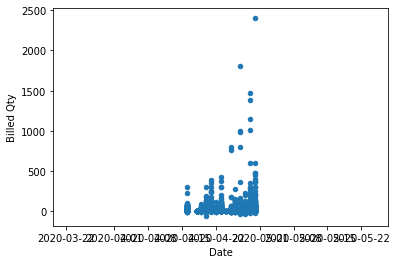

In [14]:
##Training, validation and relational datasets for Laundry products
#laundry Demand Training set - Select Jan 2016 to March 2020
laundry_jan2016_to_mar2020_demand = demand_train_laundry[(demand_train_laundry['Date'] >= '2016-01-03') & (demand_train_laundry['Date'] <= '2020-04-15')]
#laundry Demand Validation set - April 2020 
laundry_april_2020_demand = demand_train_laundry[(demand_train_laundry['Date'] >= '2020-04-16') & (demand_train_laundry['Date'] <= '2020-04-30')]
#laundry Relational Training set - Select Jan 2016 to March 2020
laundry_jan2016_to_mar2020_prices = price_train_laundry[(price_train_laundry['Date'] >= '2016-01-03') & (price_train_laundry['Date'] <= '2020-04-15')]

##Training, validation and relational datasets for Baby and Femcare products
#Bab_fem Demand Training set - Select Jan 2016 to March 2020
bab_fem_jan2016_to_mar2020_demand = demand_train_bab_fem[(demand_train_bab_fem['Date'] >= '2016-01-03') & (demand_train_bab_fem['Date'] <= '2020-04-15')]
#Bab_fem Demand Validation set - April 2020 
bab_fem_april_2020_demand = demand_train_bab_fem[(demand_train_bab_fem['Date'] >= '2020-04-16') & (demand_train_bab_fem['Date'] <= '2020-04-30')]
#Bab_fem Relational Training set - Select Jan 2016 to March 2020
bab_fem_jan2016_to_mar2020_prices = price_train_bab_fem[(price_train_bab_fem['Date'] >= '2016-01-03') & (price_train_bab_fem['Date'] <= '2020-04-15')]


# Test plot
bab_fem_april_2020_demand.plot.scatter(x='Date', y='Billed Qty')

# Convert training and validation sets into .csv files 

#Laundry demand training & validation sets to .csv
laundry_jan2016_to_mar2020_demand.to_csv("data/laundry_demand_training_dataset.csv", header = False, index = False)
laundry_april_2020_demand.to_csv("data/laundry_demand_validation_dataset.csv", header = False, index = False)

#Baby and femcare demand training & validation sets to .csv
bab_fem_jan2016_to_mar2020_demand.to_csv("data/bab_fem_demand_training_dataset.csv", header = False, index = False)
bab_fem_april_2020_demand.to_csv("data/bab_fem_demand_validation_dataset.csv", header = False, index = False)


#Relational Sets
#jan2016_to_mar2020.to_csv("data/demand_training_prices_dataset.csv", header = False, index = False)


In [ ]:
jan2016_to_mar2020
#key="elec_data/training_dataset.csv"

##Problem with this line
#boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file("data/training_dataset")

## Creating the Dataset Group and Dataset <a class="anchor" id="dataset"></a>

In Amazon Forecast , a dataset is a collection of file(s) which contain data that is relevant for a forecasting task. A dataset must conform to a schema provided by Amazon Forecast. 

More details about `Domain` and dataset type can be found on the [documentation](https://docs.aws.amazon.com/forecast/latest/dg/howitworks-domains-ds-types.html) . For this example, we are using [CUSTOM](https://docs.aws.amazon.com/forecast/latest/dg/custom-domain.html) domain with 3 required attributes `timestamp`, `target_value` and `item_id`.


It is important to also convey how Amazon Forecast can understand your time-series information. That the cell immediately below does that, the next one configures your variable names for the Project, DatasetGroup, and Dataset.

In [ ]:
DATASET_FREQUENCY = "D"  
TIMESTAMP_FORMAT = "yyyy-MM-dd"

In [ ]:
project = 'KRCPG_P&G_forecastdemo'
datasetName= project+'_ds'
datasetGroupName= project +'_dsg'
s3DataPath = "s3://"+bucket_name+"/"+key

In [ ]:
# Now save things 
%store project

### Create the Dataset Group 

In [ ]:
### Not working
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName,
                                                              Domain="CUSTOM",
                                                             )
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']

In [ ]:
### Not working
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)

In [ ]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
